# Práctica 4: Modelos del Lenguaje Neuronales

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

In [1]:
import spacy
import nltk
import torch
import numpy as np
import time
from nltk.corpus import reuters
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords

In [2]:
nltk.download('reuters')
nltk.download('stopwords')

# Configura spaCy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 10_000_000

# Carga y procesa por partes
raw_text = reuters.raw()
print(f"Tamaño del texto: {len(raw_text)} caracteres")

# Procesar por párrafos para no sobrecargar
paragraphs = raw_text.split('\n\n')
corpus = []
for para in paragraphs:
    doc = nlp(para)
    for sent in doc.sents:
        tokens = [token.text.lower() for token in sent if not token.is_punct]
        corpus.append(tokens)

print(f"Número de oraciones: {len(corpus)}")

[nltk_data] Downloading package reuters to /usr/share/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tamaño del texto: 8846853 caracteres
Número de oraciones: 55334


In [3]:
def get_words_freqs(corpus):
    freqs = {}
    for sent in corpus:
        for word in sent:
            freqs[word] = freqs.get(word, 0) + 1
    return freqs

UNK_LABEL = "<UNK>"
def get_words_indexes(freqs):
    idx_map = {}
    for idx, word in enumerate(freqs.keys()):
        if freqs[word] == 1:
            idx_map[UNK_LABEL] = len(freqs)
        else:
            idx_map[word] = idx
    return {w: i for i, w in enumerate(idx_map.keys())}, {i: w for i, w in enumerate(idx_map.keys())}

words_freqs = get_words_freqs(corpus)
words_indexes, index_to_word = get_words_indexes(words_freqs)
print(f"Vocabulario: {len(words_indexes)} palabras")

Vocabulario: 25510 palabras


In [4]:
from nltk import ngrams
def get_word_id(w_idx, word):
    return w_idx.get(word, w_idx[UNK_LABEL])

def get_train_data(corpus, w_idx, n=3):
    x_train, y_train = [], []
    for sent in corpus:
        for w1, w2, w3 in ngrams(sent, n):
            x_train.append([get_word_id(w_idx, w1), get_word_id(w_idx, w2)])
            y_train.append([get_word_id(w_idx, w3)])
    return np.array(x_train), np.array(y_train)

x_train, y_train = get_train_data(corpus, words_indexes)
train_set = np.concatenate((x_train, y_train), axis=1)

In [5]:
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
HIDDEN = 100
BATCH_SIZE = 256
EPOCHS = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

class TrigramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden)
        self.linear2 = nn.Linear(hidden, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((-1, self.context_size * self.embedding_dim))
        out = torch.tanh(self.linear1(embeds))
        out = self.linear2(out)
        return F.log_softmax(out, dim=1)

model = TrigramModel(len(words_indexes), EMBEDDING_DIM, CONTEXT_SIZE, HIDDEN).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Entrenamiento
for epoch in range(EPOCHS):
    st = time.time()
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for it, batch in enumerate(train_loader):
        # Mover TODO el batch a la GPU directamente
        batch = batch.to(device)
        context_tensor = batch[:, :2]
        target_tensor = batch[:, 2]

        model.zero_grad()
        log_probs = model(context_tensor)
        loss = loss_function(log_probs, target_tensor)
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print(f"Iter {it}, Pérdida: {loss.item():.3f}, Tiempo: {time.time()-st:.2f}s")
            st = time.time()

# Embeddings
word_embeddings_dict = {}
for idx in range(len(index_to_word)):
    word = index_to_word[idx]
    idx_tensor = torch.tensor([idx]).to(device)
    embedding = model.embeddings(idx_tensor).detach().cpu().numpy().flatten()
    word_embeddings_dict[word] = embedding

print("Embeddings generados.")


Epoch 1/3
Iter 0, Pérdida: 10.193, Tiempo: 0.59s
Iter 500, Pérdida: 6.059, Tiempo: 2.42s
Iter 1000, Pérdida: 5.755, Tiempo: 2.39s
Iter 1500, Pérdida: 5.145, Tiempo: 2.39s
Iter 2000, Pérdida: 5.569, Tiempo: 2.40s
Iter 2500, Pérdida: 5.040, Tiempo: 2.40s
Iter 3000, Pérdida: 5.310, Tiempo: 2.41s
Iter 3500, Pérdida: 5.407, Tiempo: 2.41s
Iter 4000, Pérdida: 5.368, Tiempo: 2.41s
Iter 4500, Pérdida: 5.236, Tiempo: 2.41s
Iter 5000, Pérdida: 5.190, Tiempo: 2.43s
Iter 5500, Pérdida: 4.884, Tiempo: 2.43s

Epoch 2/3
Iter 0, Pérdida: 4.377, Tiempo: 0.10s
Iter 500, Pérdida: 4.429, Tiempo: 2.42s
Iter 1000, Pérdida: 4.752, Tiempo: 2.43s
Iter 1500, Pérdida: 5.123, Tiempo: 2.44s
Iter 2000, Pérdida: 5.123, Tiempo: 2.44s
Iter 2500, Pérdida: 4.879, Tiempo: 2.44s
Iter 3000, Pérdida: 4.719, Tiempo: 2.45s
Iter 3500, Pérdida: 4.433, Tiempo: 2.46s
Iter 4000, Pérdida: 4.826, Tiempo: 2.46s
Iter 4500, Pérdida: 5.110, Tiempo: 2.47s
Iter 5000, Pérdida: 4.896, Tiempo: 2.47s
Iter 5500, Pérdida: 4.203, Tiempo: 2.48s



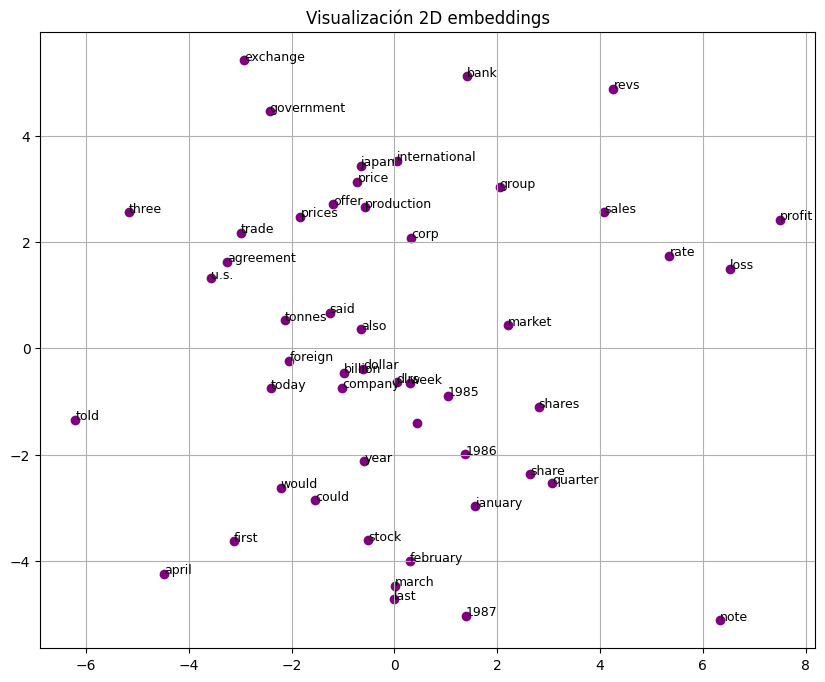

Similitud coseno entre 'price' y 'market': 0.033
Similitud coseno entre 'money' y 'bank': 0.067


In [6]:
stop_words = set(stopwords.words("english"))
sorted_words = sorted(words_freqs.items(), key=lambda x: x[1], reverse=True)
top_words = [w for w, _ in sorted_words if w not in stop_words and len(w) > 3][:50]
embeddings = np.array([word_embeddings_dict[w] for w in top_words])
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='purple')
for i, word in enumerate(top_words):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], word, fontsize=9)
plt.title("Visualización 2D embeddings")
plt.grid()
plt.show()

# Similitud coseno
def similitud_coseno(w1, w2):
    v1 = word_embeddings_dict[w1].reshape(1, -1)
    v2 = word_embeddings_dict[w2].reshape(1, -1)
    sim = cosine_similarity(v1, v2)[0][0]
    print(f"Similitud coseno entre '{w1}' y '{w2}': {sim:.3f}")

similitud_coseno("price", "market")
similitud_coseno("money", "bank")

In [8]:
import sentencepiece as spm
import os

In [9]:
with open("corpus.txt", "w", encoding="utf-8") as f:
    for sentence in reuters.sents():
        f.write(" ".join(sentence).lower() + "\n")

# Entrenamos el modelo BPE
spm.SentencePieceTrainer.Train(input="corpus.txt", model_prefix="bpe_model", vocab_size=8000, model_type="bpe")

# Cargamos el modelo
sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

# Prueba de tokenización
text = "The market is stable today."
tokens = sp.encode(text.lower(), out_type=str)
print("Subword tokens:", tokens)

Subword tokens: ['▁the', '▁market', '▁is', '▁stable', '▁today', '.']


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: bpe_model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differenti

In [10]:
# Convertimos todo el corpus en subword tokens
corpus_subword = []
for sentence in reuters.sents():
    tokens = sp.encode(" ".join(sentence).lower(), out_type=str)
    corpus_subword.append(["<BOS>"] + tokens + ["<EOS>"])

# Crear vocabulario e índices
subword_freqs = {}
for sent in corpus_subword:
    for word in sent:
        subword_freqs[word] = subword_freqs.get(word, 0) + 1

subword_to_idx = {word: idx for idx, word in enumerate(subword_freqs.keys())}
idx_to_subword = {idx: word for word, idx in subword_to_idx.items()}

In [11]:
def get_train_data(corpus, word_to_idx, n=3):
    x_train, y_train = [], []
    for sent in corpus:
        for w1, w2, w3 in ngrams(sent, n):
            x_train.append([word_to_idx[w1], word_to_idx[w2]])
            y_train.append(word_to_idx[w3])
    return np.array(x_train), np.array(y_train).reshape(-1, 1)

x_train, y_train = get_train_data(corpus_subword, subword_to_idx)

# Dataset y DataLoader
train_set = np.concatenate((x_train, y_train), axis=1)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

In [13]:
import time

EMBEDDING_DIM = 100
HIDDEN = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

class SubwordLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SubwordLM, self).__init__()
        self.context_size = 2
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(self.context_size * self.embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embeds = self.embeddings(x).view((-1, self.context_size * self.embedding_dim))
        out = torch.tanh(self.linear1(embeds))
        out = self.linear2(out)
        return F.log_softmax(out, dim=1)

model = SubwordLM(len(subword_to_idx), EMBEDDING_DIM, HIDDEN).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Entrenamiento
for epoch in range(3):
    st = time.time()
    print(f"\nEpoch {epoch+1}")
    for it, batch in enumerate(train_loader):
        batch = batch.to(device)
        context = batch[:, :2]
        target = batch[:, 2]
        model.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        if it % 500 == 0:
            print(f"Iter {it}, Loss: {loss.item():.3f}, Time: {time.time()-st:.2f}s")
            st = time.time()


Epoch 1
Iter 0, Loss: 8.999, Time: 0.15s
Iter 500, Loss: 5.495, Time: 1.17s
Iter 1000, Loss: 5.558, Time: 1.17s
Iter 1500, Loss: 5.163, Time: 1.18s
Iter 2000, Loss: 4.827, Time: 1.17s
Iter 2500, Loss: 5.179, Time: 1.21s
Iter 3000, Loss: 4.863, Time: 1.20s
Iter 3500, Loss: 4.879, Time: 1.17s
Iter 4000, Loss: 4.584, Time: 1.18s
Iter 4500, Loss: 4.529, Time: 1.16s
Iter 5000, Loss: 4.469, Time: 1.19s
Iter 5500, Loss: 4.469, Time: 1.18s
Iter 6000, Loss: 4.800, Time: 1.18s
Iter 6500, Loss: 4.468, Time: 1.17s
Iter 7000, Loss: 4.611, Time: 1.22s

Epoch 2
Iter 0, Loss: 4.788, Time: 0.11s
Iter 500, Loss: 4.211, Time: 1.20s
Iter 1000, Loss: 4.522, Time: 1.20s
Iter 1500, Loss: 4.383, Time: 1.17s
Iter 2000, Loss: 4.483, Time: 1.17s
Iter 2500, Loss: 4.554, Time: 1.16s
Iter 3000, Loss: 4.798, Time: 1.18s
Iter 3500, Loss: 4.068, Time: 1.32s
Iter 4000, Loss: 4.383, Time: 1.19s
Iter 4500, Loss: 4.294, Time: 1.18s
Iter 5000, Loss: 4.627, Time: 1.18s
Iter 5500, Loss: 4.290, Time: 1.17s
Iter 6000, Loss: 4

In [17]:
# Asegúrate de tener la clave "<UNK>" en el diccionario de subwords
if "<UNK>" not in subword_to_idx:
    subword_to_idx["<UNK>"] = len(subword_to_idx)

def generate_text(model, idx_to_subword, subword_to_idx, start_words=["the"], length=20):
    model.eval()
    context = start_words.copy()

    for _ in range(length):
        # Preparar los índices de las últimas 2 palabras del contexto
        context_ids = torch.tensor(
            [[subword_to_idx.get(w, subword_to_idx["<UNK>"]) for w in context[-2:]]],
            device=device
        )
        with torch.no_grad():
            output = model(context_ids)
            next_id = torch.argmax(output, dim=1).item()
            next_word = idx_to_subword.get(next_id, "<UNK>")
            context.append(next_word)

    return " ".join(context)

# Ejemplo de generación
generated_text = generate_text(model, idx_to_subword, subword_to_idx, start_words=["the"])
print("Texto generado:\n", generated_text)

RuntimeError: shape '[-1, 200]' is invalid for input of size 100